In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('seaborn-white')
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)
plt.rc('font', family='sans-serif')
plt.rc('font', family='sans-serif')
%config InlineBackend.figure_format = 'retina'

In [2]:
def get_mpsa_brca2_ikbkap_data():
    """
    1. Get data from the MPSA database (BRCA2/IKBKAP 2018).
    2. Devide Psi = PSI/100
    3. Returns the log(Psi)
    """
    psi_df = pd.read_csv('psi_5ss_2018_brca2_ikbkap_smn1.gz')
    psi_df.dropna(inplace=True)
    cond = (psi_df['brca2_9nt'] > 0) & (psi_df['ikbkap_9nt']) > 0
    psi_df = psi_df[cond]
    psi_df.reset_index(inplace=True, drop=True)
    brca2_psi = psi_df['brca2_9nt'].values/100.
    ikbkap_psi = psi_df['ikbkap_9nt'].values/100.

    return np.log(brca2_psi), np.log(ikbkap_psi)

In [3]:
def allelic_manifold(alpha, c, Nx, Ny, w):
    num = w**2+(alpha+1)*w
    denum = num+alpha
    x = num/denum + Nx
    num = (c*w)**2+(c*w)*(alpha+1)
    denum = num+alpha
    y = num/denum + Ny
    return np.log(x), np.log(y)

In [4]:
filename = './res_N500_C4_W1000_fixed_noise.nc'

In [5]:
# Get the original data
x_orig, y_orig = get_mpsa_brca2_ikbkap_data()

In [6]:
# Read the inference data
res_az = az.from_netcdf(filename)
# Training Data
x = res_az['observed_data']['obs'][:, 0]
y = res_az['observed_data']['obs'][:, 1]

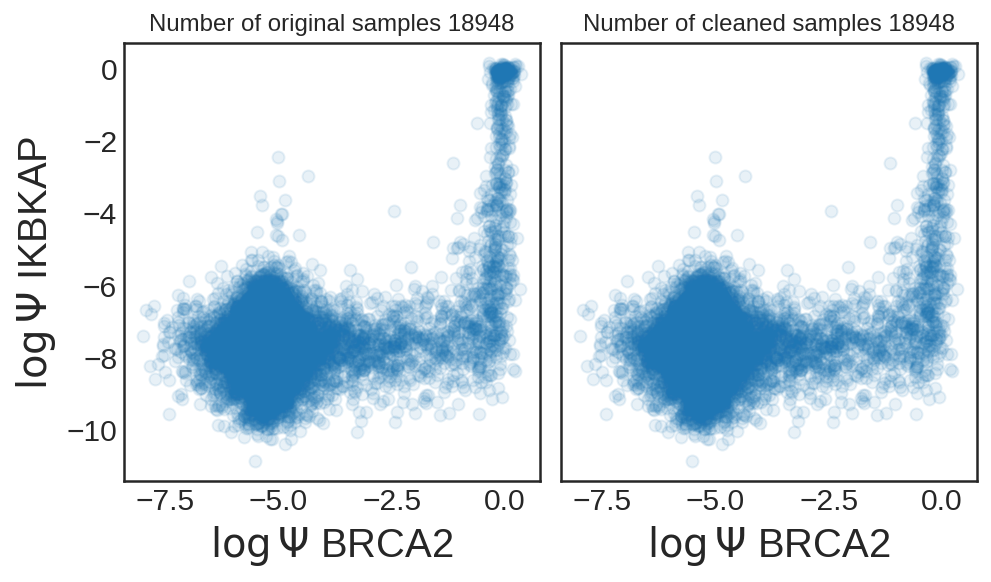

In [7]:
fig, axs = plt.subplots(1,2, figsize=(7,5/1.2), sharey=True)
axs[0].scatter(x_orig, y_orig, alpha=0.1, rasterized=True)
axs[0].set_title(f'Number of original samples {x_orig.shape[0]}')
axs[1].scatter(x, y, alpha=0.1, rasterized=True)
axs[1].set_title(f'Number of cleaned samples {x.shape[0]}')

axs[0].set_xlabel(r'$\log \Psi$ BRCA2')
axs[1].set_xlabel(r'$\log \Psi$ BRCA2')
axs[0].set_ylabel(r'$\log \Psi$ IKBKAP')
plt.tight_layout()
# plt.savefig('original_vs_cleaned_data.pdf')

In [ ]:
# Summary statistics
summary_df = az.summary(res_az, hdi_prob=0.95)
summary_df

/home/mahdik/apps/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


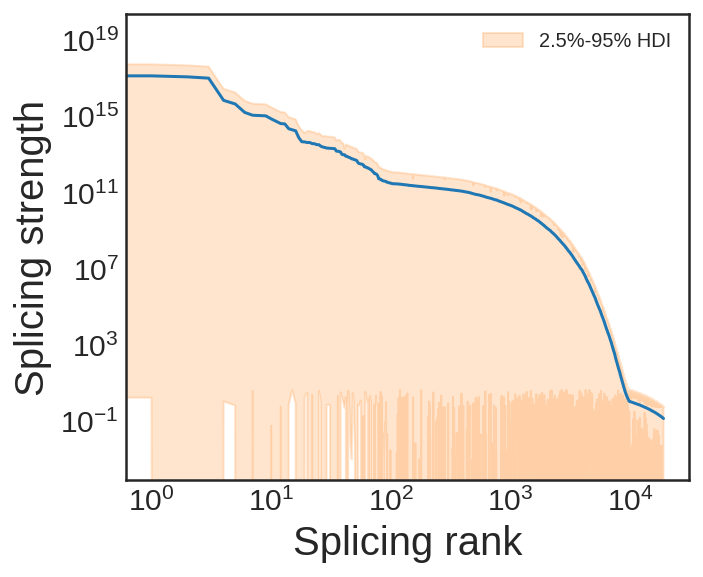

In [9]:
w_infer = summary_df[summary_df.index.str.startswith('w')].copy()
w_infer.sort_values(by='mean', inplace=True, ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(5,5/1.2))
ss_idx = np.arange(len(w_infer))
ax.plot(ss_idx, w_infer['mean'].values)
ax.fill_between(ss_idx, w_infer['hdi_2.5%'], w_infer['hdi_97.5%'],
                color='C1', alpha=0.2, label=r'2.5%-95% HDI')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Splicing rank')
ax.set_ylabel('Splicing strength')
# ax.set_ylim([1e-5, 1e15])
ax.legend()
plt.tight_layout()
# plt.savefig('splicing_strength.pdf')

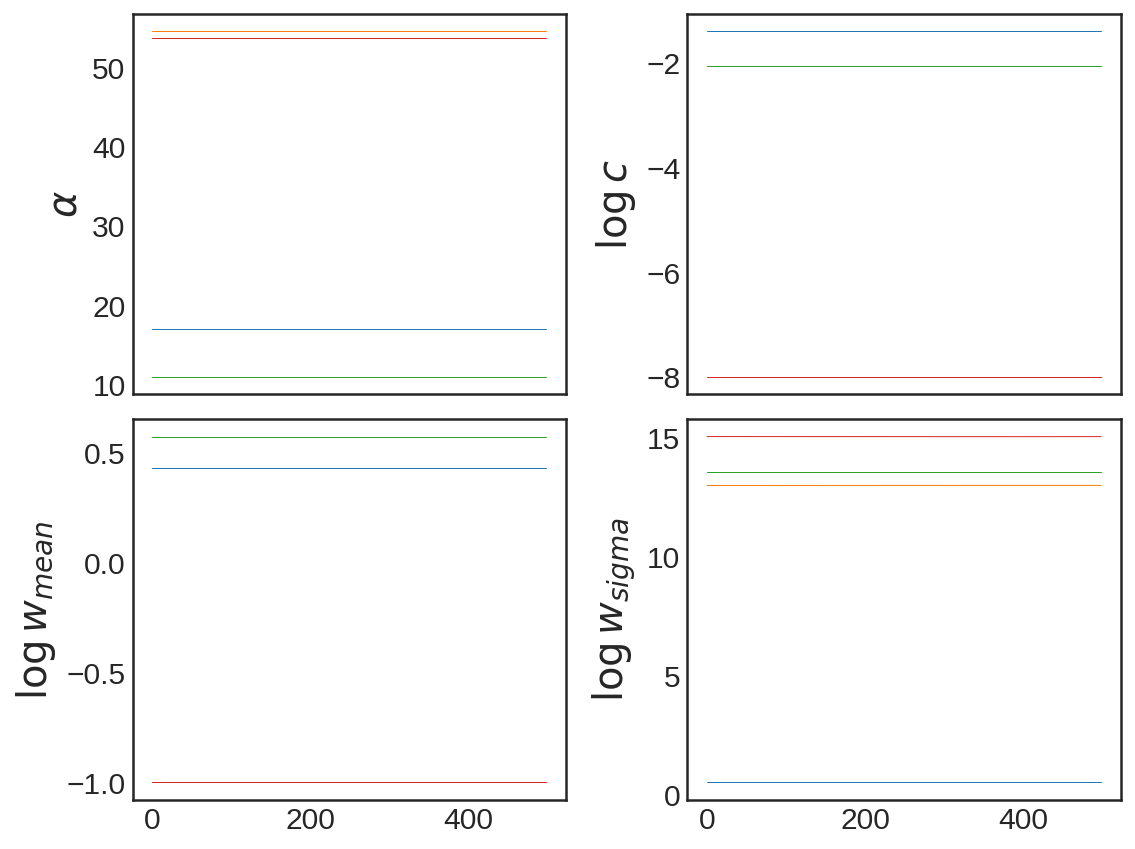

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(8,6), sharex=True)
for i in res_az.posterior['chain'].values:
    axs[0,0].plot(res_az['posterior']['alpha'][i,:], linewidth=0.5)
    axs[0,1].plot(res_az['posterior']['log_c'][i,:], linewidth=0.5)
    axs[1,0].plot(res_az['posterior']['log_w_mean'][i,:], linewidth=0.5)
    axs[1,1].plot(res_az['posterior']['log_w_sigma'][i,:], linewidth=0.5)


axs[0,0].set_ylabel(r'$\alpha$')
axs[0,1].set_ylabel(r'$\log c$')
axs[1,0].set_ylabel(r'$\log w_{mean}$')
axs[1,1].set_ylabel(r'$\log w_{sigma}$')


plt.tight_layout()
# plt.savefig('scalar_traces.pdf')

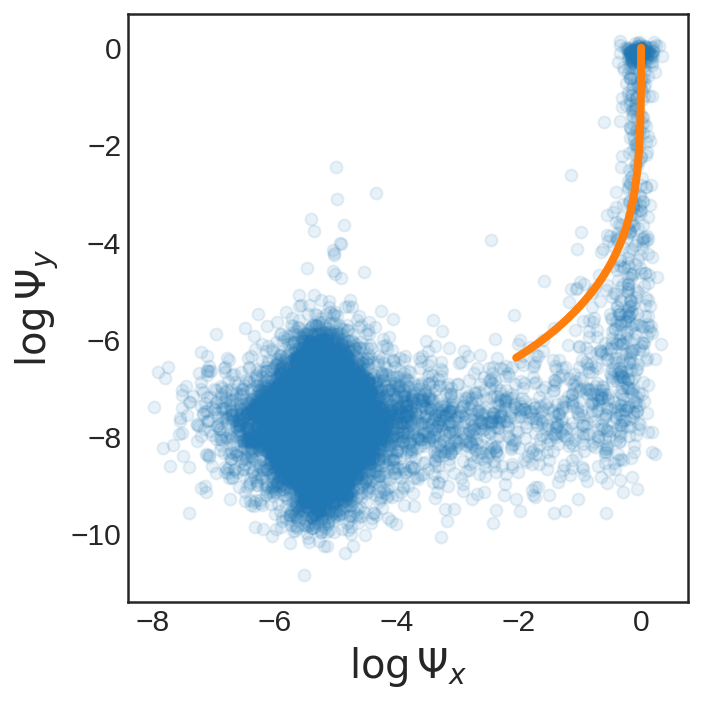

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(x, y, alpha=0.1)
alpha_mean = np.exp(summary_df['mean']['log_alpha'])
c_mean = np.exp(summary_df['mean']['log_c'])
Nx_mean = 0.0056
Ny_mean = 0.000604
w_mean = np.sort(w_infer['mean'])
x_mean, y_mean = allelic_manifold(alpha_mean, c_mean, Nx_mean, Ny_mean, w_mean)
ax.plot(x_mean, y_mean, c='C1', linewidth=4)
ax.set_xlabel(r'$\log \Psi_x$')
ax.set_ylabel(r'$\log \Psi_y$')

plt.tight_layout()
# plt.savefig('allelic_manifold.pdf')

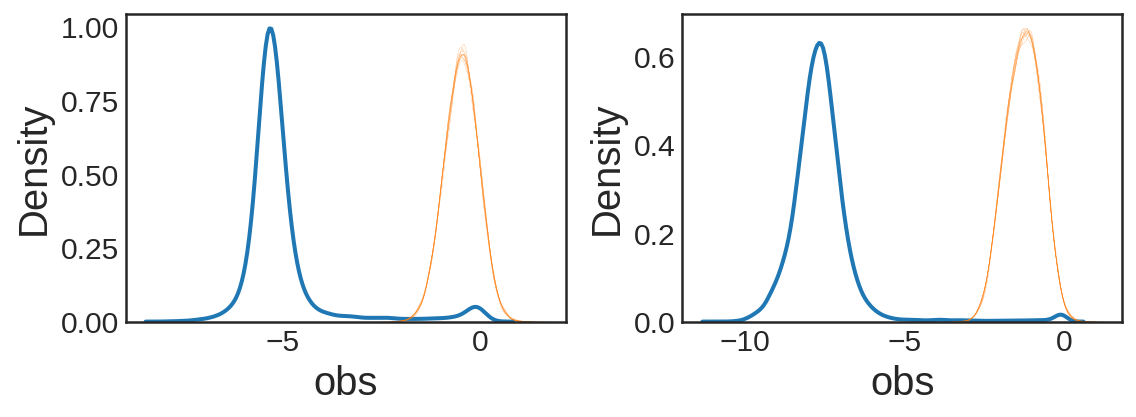

In [12]:
# Posterior Predictive plot
obs_posterior_predictive = res_az['posterior_predictive']['obs'].stack(draws=("chain", "draw"))
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sns.kdeplot(x, ax=axs[0], label='observation', linewidth=2)
sns.kdeplot(y, ax=axs[1], label='observation', linewidth=2)
for i in range(10):
    if i == 0:
        label = 'Posterior Predictive'
    else:
        label = None

    sns.kdeplot(obs_posterior_predictive[:, 0, i],
                    ax=axs[0], c='C1', linewidth=0.1,
                    label=label)

    sns.kdeplot(obs_posterior_predictive[:, 1, i],
                    ax=axs[1], c='C1', linewidth=0.1,
                    label=label)
plt.tight_layout()
# plt.savefig('density_estimate_obs.pdf')

In [13]:
# Combine chains in posteriors
posteriors = res_az.posterior.stack(draws=("chain", "draw"))

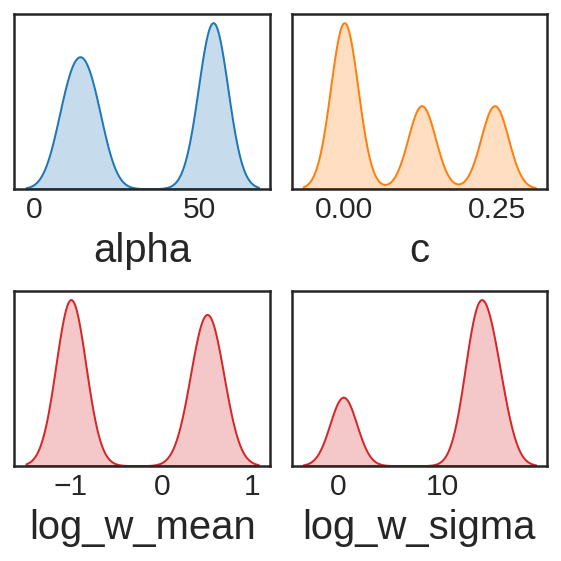

In [19]:
fig, axs = plt.subplots(2,2, figsize=(4,4))
sns.kdeplot(posteriors['alpha'], ax=axs[0,0], shade=True, color='C0')
sns.kdeplot(posteriors['c'], ax=axs[0,1], shade=True, color='C1')
sns.kdeplot(posteriors['log_w_mean'], ax=axs[1,0], shade=True, color='C3')
sns.kdeplot(posteriors['log_w_sigma'], ax=axs[1,1], shade=True, color='C3')

for i in range(2):
    for j in range(2):
        axs[i,j].set_ylabel('')
        axs[i,j].set_yticks([])
    
plt.tight_layout()
# plt.savefig('scalars_dist.pdf')